In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from tqdm.notebook import tqdm

In [2]:
# global plotting settings
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 150

# Creating the data

- Similar to the dataset created in Tutorial 1
- We just have more datapoints, and a smaller domain

In [3]:
N_data = 50000

data_x = np.linspace(1.0, 20.0, N_data)[:, np.newaxis]
data_y = 0.02*data_x + 0.3*np.sin(data_x) + 1e-1  * np.log( data_x ) **2 + 0.2*np.random.randn(N_data,1)

data_x.shape, data_y.shape

((50000, 1), (50000, 1))

### Note:
Inputs to `PyTorch` models have the shape `(Nexamples, Ndatashape, ..., Nfeatures)`
- `Nexamples`: usually the batch size
- `Ndatashape, ...`: the features in each example might live in an overarching structure, for example, images, graphs, or sequences
- `Nfeatures`: the final dimension stores the feature vector for each example

Text(0, 0.5, 'temperature')

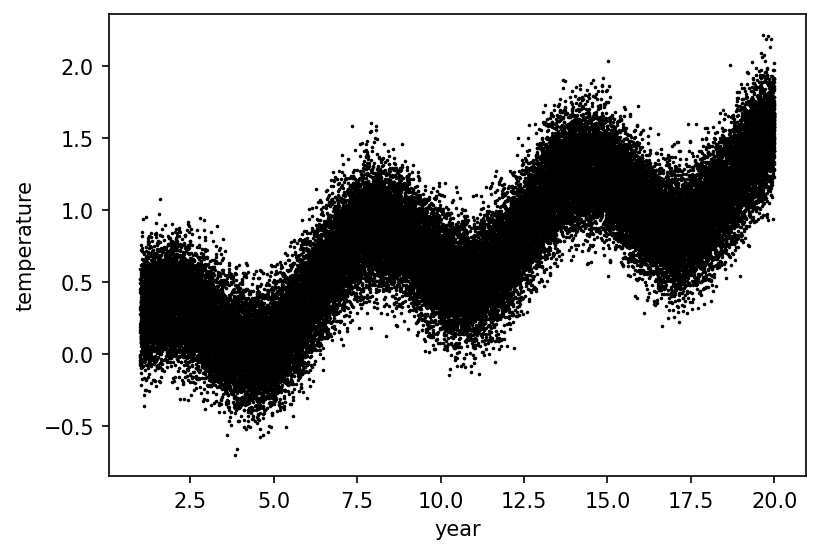

In [4]:
plt.scatter( data_x.flatten(), data_y.flatten(), s=0.5, color='black')
plt.xlabel('year')
plt.ylabel('temperature')

### Splitting into train and validation
- train examples are used to guide the model's optimization
- validation examples are used to check for overtraining during training
- test examples are like validation but they are reserved for studying performance after training

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(data_x, data_y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = X_train.astype(np.float32), X_valid.astype(np.float32), y_train.astype(np.float32), y_valid.astype(np.float32)

X_train.shape, y_train.shape

((40000, 1), (40000, 1))

# Let's try to fit the data using `PyTorch` this time...

### 1. `Dataset`

![Alt text](images/raw_data_to_dataset.png)

There are 3 important methods to overload when creating a custom dataset class inheriting from torch.utils.data.Dataset
- `__init__`: usually this is where the reference to the input data is made. **Note**: `super().__init__()` does nothing, so is not needed.
- `__len__`: this tells `PyTorch` how to figure out how many examples are in the full dataset.
- `__getitem__`: this is how to fetch a single example.

**Note**: At some point in the dataset, the data should be converted to `torch.Tensor` format.

In [6]:
class TempDataset(Dataset):

    def __init__(self, x, y):
        self.x = torch.tensor(x)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]


In [7]:
train_ds = TempDataset(X_train, y_train)
valid_ds = TempDataset(X_valid, y_valid)

### 2. `DataLoader`

![Alt text](images/dataloader.png)

In [8]:
train_dl = DataLoader(train_ds, batch_size=250, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=250, shuffle=False)

### 3. `nn.Module`
There are 2 important methods when creating a model class inheriting from `torch.nn.Module`
- `__init__`: instantiates the layers of the model. **Note**: `super().__init__()` is important!
- `forward`: this tells `PyTorch` how to pass the input `torch.Tensor` through the model's layers.

###  **Example 1:** linear regression
As in Tutorial 1, create a model which has two learnable parameters, $m$ and $c$:

$y$ = mx + c

i.e. `nn.Linear(1, 1, bias=True)`

In [9]:
class TempNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(1, 1, bias=True)

    def forward(self, x):
        out = self.layer(x)
        return out

# Training loop

This is the simplified conceptual process:
```
Loop over epochs:
    Loop over batches in dataloader:
        use model to predict y for input x
        compute loss between predicted and target y
        update the model
```

In [10]:
def train_model(model, train_dl, valid_dl, epochs=50):

    # for storing the losses after each epoch
    loss_dict = {
        'train': [],
        'valid': []
    }

    # choose the optimizer (Adam is very popular)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # choose the loss function
    loss_fn = nn.MSELoss(reduction='mean')

    for ep in tqdm(range(epochs)):

        ### (A) train model
        # put the model in training mode (not relevant for this simple model, but good practice)
        model.train()
        for xb, yb in train_dl:

            # set all the gradients to zero
            optimizer.zero_grad()

            # forward pass
            pred = model(xb)

            # calculate the loss
            loss = loss_fn(pred, yb)

            # compute the gradients
            loss.backward()

            # take a step (i.e. update the network)
            optimizer.step()

        ### (B) evaluate model

        # put the model in evaluation mode (not relevant for this simple model, but good practice)
        model.eval()

        # this function gets the loss averaged an entire dataset
        get_mean_loss = lambda dl: np.mean([loss_fn(model(xb), yb).item() for xb, yb in dl])

        # use torch.no_grad() since we don't need to compute gradients (more memory efficient, but not strictly necessary)
        with torch.no_grad():
            loss_dict['train'].append(get_mean_loss(train_dl))
            loss_dict['valid'].append(get_mean_loss(valid_dl))
        
    return loss_dict

In [11]:
model = TempNN()
loss_dict = train_model(model, train_dl, valid_dl, epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

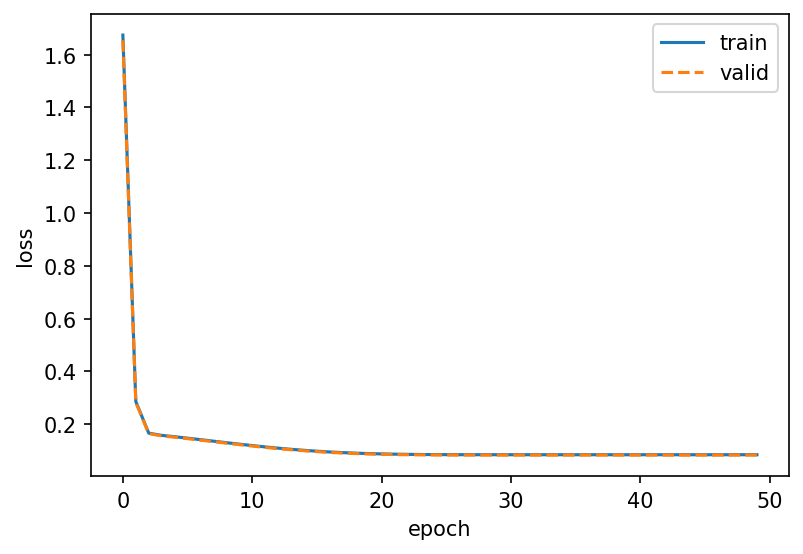

In [12]:
def plot_loss(loss_dict):
    plt.plot(loss_dict['train'], label='train')
    plt.plot(loss_dict['valid'], label='valid', linestyle='--')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

plot_loss(loss_dict)

# Inference

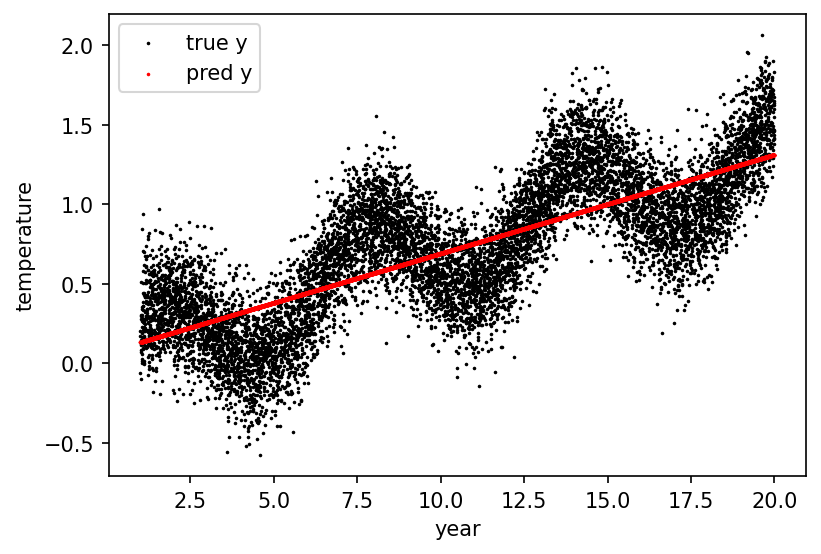

In [13]:
def plot_performance(model, ds):

    # get all the predicted Y over the whole dataset
    X, Y_true = ds.x, ds.y
    # predict all the ys using the model
    Y_pred = model(X).detach()

    plt.scatter(X.numpy().flatten(), Y_true.numpy().flatten(), s=0.5, color='black', label='true y')
    plt.scatter(X.numpy().flatten(), Y_pred.numpy().flatten(), s=0.5, color='red', label='pred y')
    plt.legend()
    plt.xlabel('year')
    plt.ylabel('temperature')
    plt.show()

plot_performance(model, valid_ds)

In [14]:
print("Best parameter values:")
best_weight = model.layer.weight.item()
best_bias = model.layer.bias.item()
print(f"weight: {best_weight:.3f}")
print(f"bias: {best_bias:.3f}")

Best parameter values:
weight: 0.062
bias: 0.070


###  **Aside 1:** `torch.autograd`

What's really happening when we call `loss.backward()`?

For more info, read https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

In [15]:
untrained_model = TempNN()
print(untrained_model.layer.weight)
print(untrained_model.layer.bias)

Parameter containing:
tensor([[-0.1497]], requires_grad=True)
Parameter containing:
tensor([0.3369], requires_grad=True)


Notice `requires_grad=True`. By default, this is switched on for parameters inside NN layers, meaning that they are ready for gradient computation.

In [16]:
untrained_model.zero_grad() # clear gradients

# grab the full X and Y from our dataset
X     = train_ds.x
Ytrue = train_ds.y

# this is what we were doing in the training loop
Ypred = untrained_model(X)
loss = nn.MSELoss(reduction='mean')(Ypred, Ytrue)

At this point, the parameters have no gradients! (i.e. `.grad` is `None`)

In [17]:
print(untrained_model.layer.weight.grad)
print(untrained_model.layer.bias.grad)

None
None


Using `torch.autograd`, we can compute the gradients of the loss with respect to each parameter automatically

In [18]:
dloss_dw = torch.autograd.grad(loss, untrained_model.layer.weight, retain_graph=True)[0]
dloss_db = torch.autograd.grad(loss, untrained_model.layer.bias, retain_graph=True)[0]

print('dloss_dw:', dloss_dw)
print('dloss_db:', dloss_db)

dloss_dw: tensor([[-54.0801]])
dloss_db: tensor([-3.9279])


Usually, when training, we use a shortcut `loss.backward()` to compute the gradient for _all_ model parameters in one go...

(this is useful if you have millions of them!)

In [19]:
loss.backward()
print(untrained_model.layer.weight.grad)
print(untrained_model.layer.bias.grad)

tensor([[-54.0801]])
tensor([-3.9279])


These values are identical to what we got using `torch.autograd.grad` above! ✅

###  **Aside 2:** Plotting gradients on the loss landscape

1) Let's plot the loss function for a grid of $(w, b)$ values
2) Let's also plot the gradients!

In [21]:
N_points = 30

w_grid = np.linspace(best_weight*0.98, best_weight*1.02, N_points)
b_grid = np.linspace(best_bias*0.8, best_bias*1.2, N_points)

w_grid, b_grid = np.meshgrid(w_grid, b_grid)
loss_grid = np.zeros_like(w_grid)
dloss_dw_grid = np.zeros_like(w_grid)
dloss_db_grid = np.zeros_like(w_grid)

for i in tqdm(range(w_grid.shape[0])):
    for j in range(w_grid.shape[1]):

        # set the model parameters to the values at this point in the grid
        untrained_model.layer.weight.data.fill_(w_grid[i,j])
        untrained_model.layer.bias.data.fill_(b_grid[i,j])

        # set the gradients to zero
        untrained_model.zero_grad()

        # compute the loss
        Ypred = untrained_model(X)
        loss = nn.MSELoss(reduction='mean')(Ypred, Ytrue)
        loss_grid[i,j] = loss.item()

        # compute the gradients
        dloss_dw = torch.autograd.grad(loss, untrained_model.layer.weight, retain_graph=True)[0]
        dloss_db = torch.autograd.grad(loss, untrained_model.layer.bias, retain_graph=True)[0]
        dloss_dw_grid[i,j] = dloss_dw.item()
        dloss_db_grid[i,j] = dloss_db.item()

  0%|          | 0/30 [00:00<?, ?it/s]

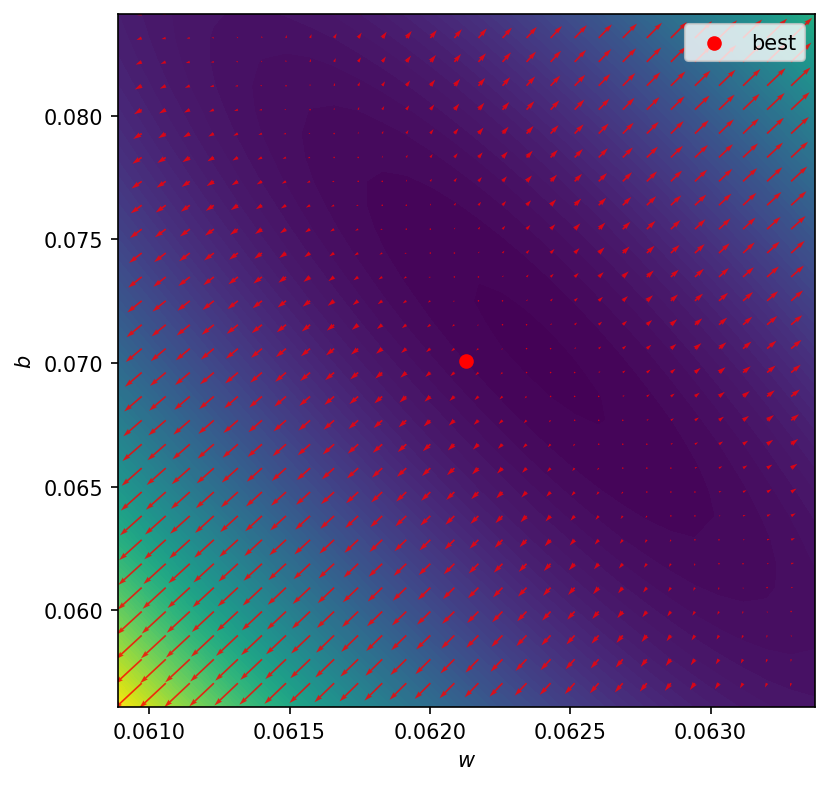

In [22]:
aspect = (b_grid.max() - b_grid.min()) / (w_grid.max() - w_grid.min())
plt.figure(figsize=(6, 6))
plt.contourf(w_grid, b_grid, loss_grid, levels=100)
plt.scatter(best_weight, best_bias, color='red', label='best')
plt.quiver(w_grid, b_grid, dloss_dw_grid/aspect, dloss_db_grid*aspect, color='red', angles='xy', scale_units='xy', alpha=0.8)
plt.xlabel('$w$')
plt.ylabel('$b$')
plt.legend()
plt.show()

###  **Example 2:** Now let's try using a more powerful model!
Recall that in the previous example, the model comprised a single neuron with _no nonlinearity_! 

Now let's:
- increase the number of layers from 1 to 4
- increase the number of neurons per layer from 1 to 64
- add nonlinear activation functions between hidden layers

![Alt text](images/NN_building.png)

In [23]:
class TempNN2(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(1, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 64)
        self.layer4 = nn.Linear(64, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        out = self.layer1(x)
        out = self.activation(out)
        out = self.layer2(out)
        out = self.activation(out)
        out = self.layer3(out)
        out = self.activation(out)
        out = self.layer4(out)
        return out

In [24]:
model2 = TempNN2()
loss_dict2 = train_model(model2, train_dl, valid_dl, epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

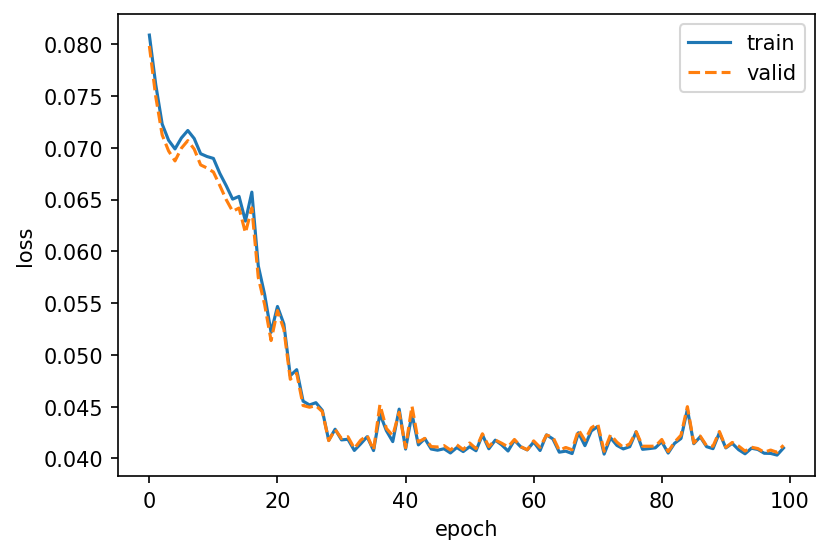

In [25]:
plot_loss(loss_dict2)

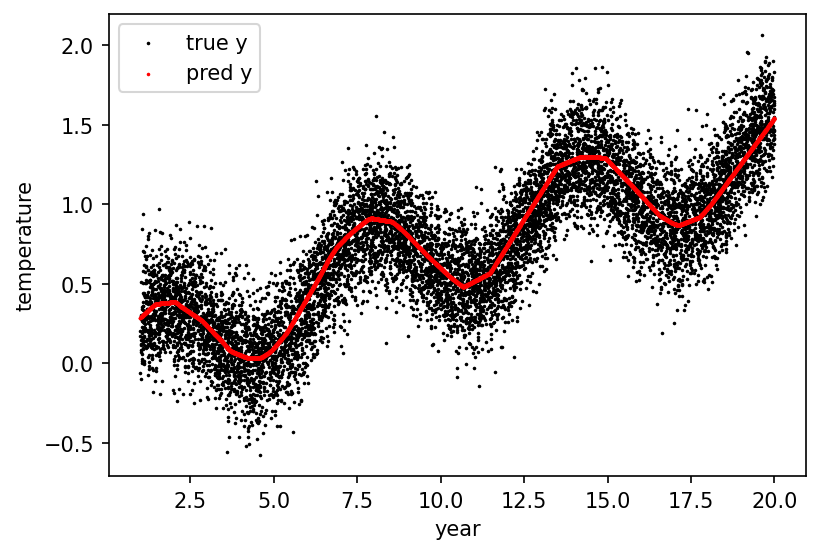

In [26]:
plot_performance(model2, valid_ds)